In [ ]:
# ============================================================================
# PARTIE 1: IMPORTS ET CONFIGURATION
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Montage du Drive
drive.mount('/content/drive')

# Chemins et configuration
dataset_path = "/content/drive/MyDrive/AudioWAV"  # VOTRE DOSSIER AUDIO WAV

# Hyperparamètres
IMG_HEIGHT = 128
IMG_WIDTH = 128
N_MELS = 128
TIME_STEPS = 130
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS_AE = 30
EPOCHS_CLASSIFIER = 25
EPOCHS_FINETUNE = 35

# Classes d'émotions
EMOTIONS = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

print("✅ Configuration chargée avec succès!")
print(f"📂 Dossier de données: {dataset_path}")
print(f"🎭 Émotions à détecter: {EMOTIONS}")

Mounted at /content/drive
✅ Configuration chargée avec succès!
📂 Dossier de données: /content/drive/MyDrive/AudioWAV
🎭 Émotions à détecter: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

QUESTION 1: EXTRACTION ET PRÉTRAITEMENT DES FEATURES AUDIO
Nombre de fichiers audio trouvés: 7446
Spectrogrammes extraits: 7446
Shape des spectrogrammes: (7446, 128, 130)
Équivalent vidéo serait: (n_samples, H, W) avant d'ajouter le channel

Distribution des émotions:
ANG: 1271 échantillons
DIS: 1272 échantillons
FEA: 1271 échantillons
HAP: 1271 échantillons
NEU: 1087 échantillons
SAD: 1274 échantillons

Shape finale des données: (7446, 128, 130, 1)
Format: (n_samples, n_mels, time_steps, channels)
Équivalent vidéo: (n_samples, H, W, C)

Split des données:
  Train: (5212, 128, 130, 1)
  Validation: (1117, 128, 130, 1)
  Test: (1117, 128, 130, 1)


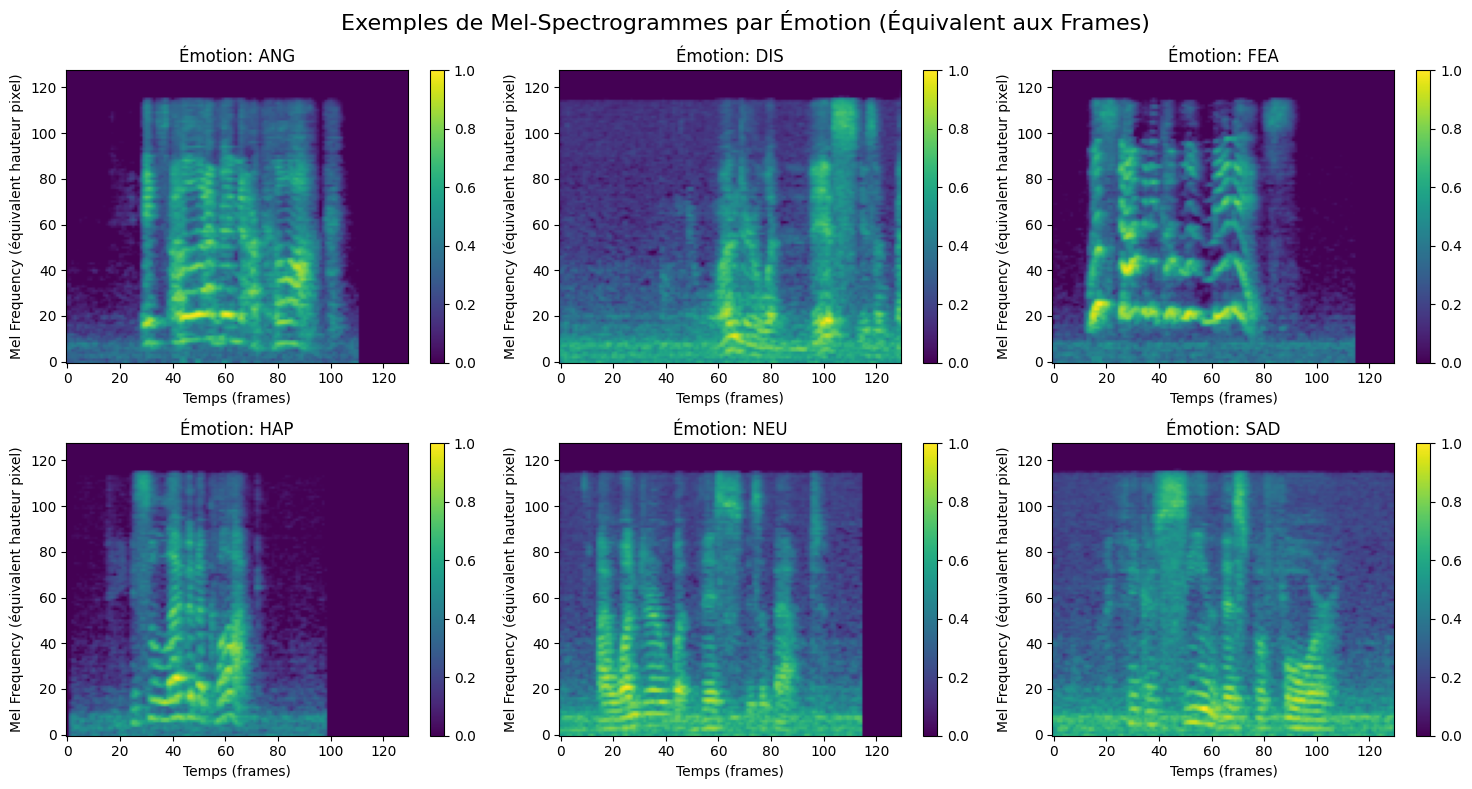


✅ QUESTION 1 COMPLÉTÉE!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# QUESTION 1: EXTRACT AND PREPROCESS AUDIO FEATURES
# ============================================================================
# Adapté de l'extraction de frames vidéo vers l'extraction de features audio
# Au lieu de frames vidéo (T × H × W × C), on utilise mel-spectrogrammes (N_MELS × TIME_STEPS × 1)

from google.colab import drive
drive.mount('/content/drive')

# Configuration
DATASET_PATH = "/content/drive/MyDrive/AudioWAV"
SAMPLE_RATE = 22050
N_MELS = 128  # Équivalent à la hauteur H d'une frame
TIME_STEPS = 130  # Équivalent à la largeur W d'une frame
DURATION = 3  # secondes
EMOTIONS = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

def extract_melspectrogram(audio_path, sr=22050, n_mels=128, target_length=130):
    """
    Extrait un mel-spectrogramme d'un fichier audio avec une longueur fixe.

    Équivalent vidéo: Extraire et redimensionner des frames
    Audio: Extraire et normaliser des spectrogrammes

    Args:
        audio_path: Chemin vers le fichier audio
        sr: Sample rate
        n_mels: Nombre de bandes mel (équivalent à la hauteur H)
        target_length: Longueur temporelle cible (équivalent à la largeur W)

    Returns:
        mel_spec_norm: Spectrogramme normalisé (n_mels, target_length)
    """
    try:
        # Charger l'audio avec une durée fixe
        y, sr = librosa.load(audio_path, sr=sr, duration=DURATION)

        # Générer le mel-spectrogramme (équivalent à extraire une frame)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normaliser entre 0 et 1 (équivalent à normaliser les pixels)
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

        # Ajuster la longueur temporelle (équivalent à redimensionner)
        current_length = mel_spec_norm.shape[1]

        if current_length < target_length:
            # Padding si trop court
            pad_width = target_length - current_length
            mel_spec_norm = np.pad(mel_spec_norm, ((0, 0), (0, pad_width)), mode='constant')
        elif current_length > target_length:
            # Tronquer si trop long
            mel_spec_norm = mel_spec_norm[:, :target_length]

        return mel_spec_norm

    except Exception as e:
        print(f"Erreur lors du traitement de {audio_path}: {e}")
        return None


def load_dataset(dataset_path, target_length=130):
    """
    Charge tous les fichiers audio et extrait les mel-spectrogrammes.

    Équivalent vidéo: Charger toutes les vidéos et extraire les frames
    """
    audio_files = list(Path(dataset_path).glob("*.wav"))

    if len(audio_files) == 0:
        raise ValueError(f"Aucun fichier .wav trouvé dans {dataset_path}")

    print(f"Nombre de fichiers audio trouvés: {len(audio_files)}")

    spectrograms = []
    labels = []

    for audio_file in audio_files:
        filename = audio_file.stem
        parts = filename.split('_')

        if len(parts) >= 3:
            emotion = parts[2]

            if emotion in EMOTIONS:
                mel_spec = extract_melspectrogram(str(audio_file), target_length=target_length)

                if mel_spec is not None:
                    spectrograms.append(mel_spec)
                    labels.append(emotion)

    print(f"Spectrogrammes extraits: {len(spectrograms)}")

    spectrograms = np.array(spectrograms)
    labels = np.array(labels)

    print(f"Shape des spectrogrammes: {spectrograms.shape}")
    print(f"Équivalent vidéo serait: (n_samples, H, W) avant d'ajouter le channel")

    return spectrograms, labels


# Charger les données
print("\n" + "="*70)
print("QUESTION 1: EXTRACTION ET PRÉTRAITEMENT DES FEATURES AUDIO")
print("="*70)

X_data, y_data = load_dataset(DATASET_PATH, target_length=TIME_STEPS)

# Afficher la distribution des émotions
unique, counts = np.unique(y_data, return_counts=True)
print("\nDistribution des émotions:")
for emotion, count in zip(unique, counts):
    print(f"{emotion}: {count} échantillons")

# Encoder les labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

# Ajouter dimension channel pour CNN (équivalent au channel couleur des images)
X_data = np.expand_dims(X_data, axis=-1)

print(f"\nShape finale des données: {X_data.shape}")
print(f"Format: (n_samples, n_mels, time_steps, channels)")
print(f"Équivalent vidéo: (n_samples, H, W, C)")

# Split train/validation/test
from tensorflow.keras.utils import to_categorical

y_categorical = to_categorical(y_encoded, num_classes=len(EMOTIONS))

X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"\nSplit des données:")
print(f"  Train: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")

# Visualiser quelques exemples
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Exemples de Mel-Spectrogrammes par Émotion (Équivalent aux Frames)', fontsize=16)

for idx, emotion in enumerate(EMOTIONS):
    emotion_idx = np.where(y_data == emotion)[0][0]
    ax = axes[idx // 3, idx % 3]
    img = ax.imshow(X_data[emotion_idx, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Émotion: {emotion}')
    ax.set_xlabel('Temps (frames)')
    ax.set_ylabel('Mel Frequency (équivalent hauteur pixel)')
    plt.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

print("\n✅ QUESTION 1 COMPLÉTÉE!")
print("="*70)


QUESTION 2: CONSTRUCTION ET ENTRAÎNEMENT DE L'AUTOENCODER

--- Construction de l'Encoder ---
  Après Block 1: (64, 65, 32) (64×65×32)
  Après Block 2: (32, 32, 64) (32×32×64)
  Après Block 3: (16, 16, 128) (16×16×128)
  Espace latent: (64,)

--- Construction du Decoder ---
  Après reshape: (16, 16, 128) (16×16×128)
  Après Block 1: (32, 32, 128) (32×32×128)
  Après Block 2: (64, 64, 64) (64×64×64)
  Après Block 3: (128, 128, 32) (128×128×32)
  Sortie finale: (128, 130, 1) (128×130×1)

ARCHITECTURES DES MODÈLES

1. ENCODER (Compresseur):
----------------------------------------


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 130, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn1 (BatchNormalization)    │ (None, 128, 130, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn2 (BatchNormalization)    │ (None, 64, 65, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling2D)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv3 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn3 (BatchNormalization)    │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool3 (MaxPooling2D)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_flatten (Flatten)           │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 64)             │     2,097,216 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,784 (8.36 MB)

 Trainable params: 2,190,336 (8.36 MB)

 Non-trainable params: 448 (1.75 KB)


2. DECODER (Reconstructeur):
----------------------------------------


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense (Dense)               │ (None, 32768)          │     2,129,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_reshape (Reshape)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2DTranspose)     │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up1 (UpSampling2D)          │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2DTranspose)     │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up2 (UpSampling2D)          │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv3 (Conv2DTranspose)     │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up3 (UpSampling2D)          │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Conv2D)             │ (None, 128, 128, 1)    │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_padding (ZeroPadding2D)     │ (None, 128, 130, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,370,049 (9.04 MB)

 Trainable params: 2,370,049 (9.04 MB)

 Non-trainable params: 0 (0.00 B)


3. AUTOENCODER COMPLET:
----------------------------------------


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 130, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │     2,190,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 130, 1)    │     2,370,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,560,833 (17.40 MB)

 Trainable params: 4,560,385 (17.40 MB)

 Non-trainable params: 448 (1.75 KB)


STATISTIQUES DE COMPRESSION
Taille originale: 16640 paramètres
Taille compressée: 64 paramètres
Ratio de compression: 260.00x
Réduction: 99.6%


--- Compilation de l'Autoencoder ---
✅ Modèle compilé avec:
  - Optimizer: Adam (lr=0.001)
  - Loss: MSE (Mean Squared Error)
  - Metrics: MAE (Mean Absolute Error)

PRÉ-ENTRAÎNEMENT DE L'AUTOENCODER (UNSUPERVISED LEARNING)

⚠️  IMPORTANT: L'autoencoder apprend à reconstruire l'input
   SANS utiliser les labels d'émotions (apprentissage non supervisé)!

Début de l'entraînement...
Epochs: 30
Batch size: 32
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0230 - mae: 0.1019
Epoch 1: val_loss did not improve from inf
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - loss: 0.0230 - mae: 0.1017 - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0086 - mae: 0.0603
Epoch 2: val_loss did not improve from inf
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0086 - mae: 0.06

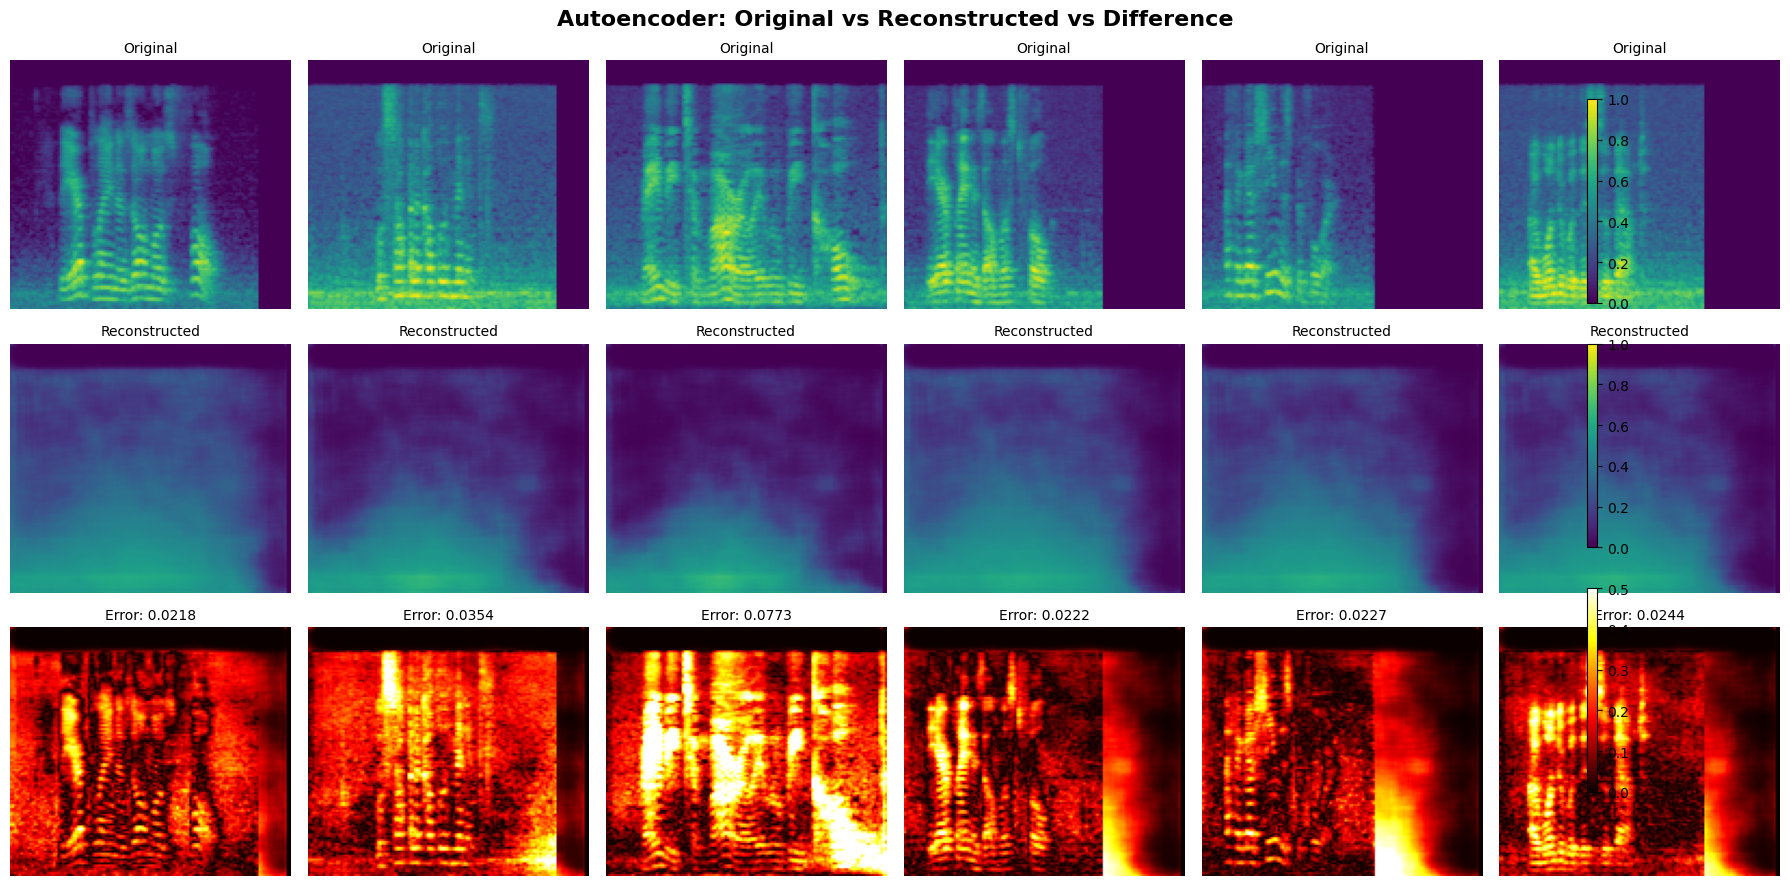

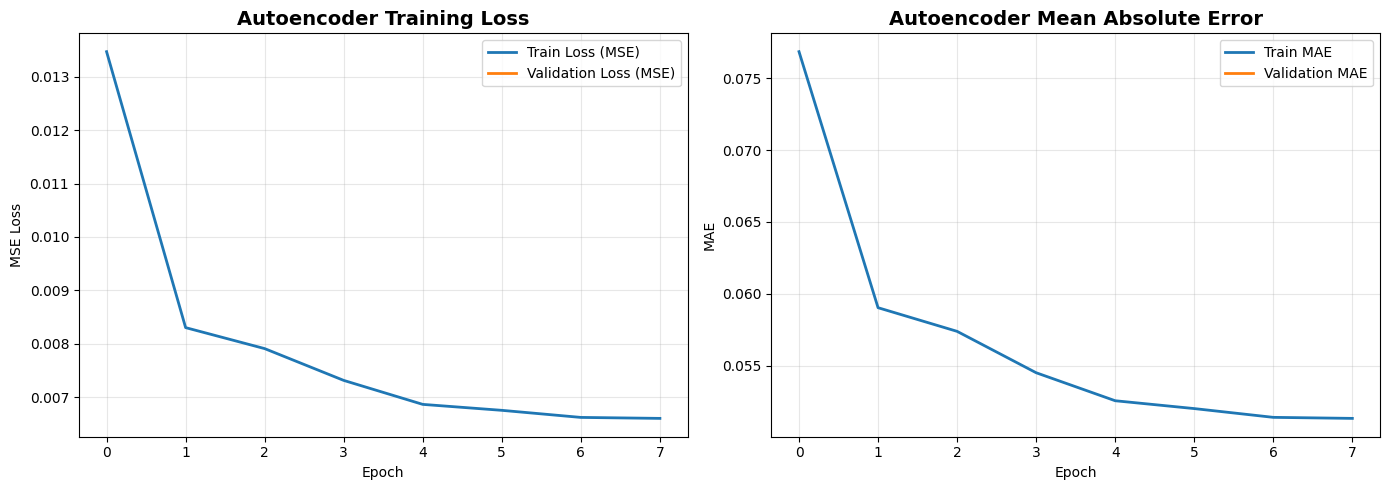


--- Analyse de l'espace latent ---

Shape des représentations latentes: (1117, 64)
Min: 0.0000
Max: 55.2492
Mean: 6.3687
Std: 6.1327


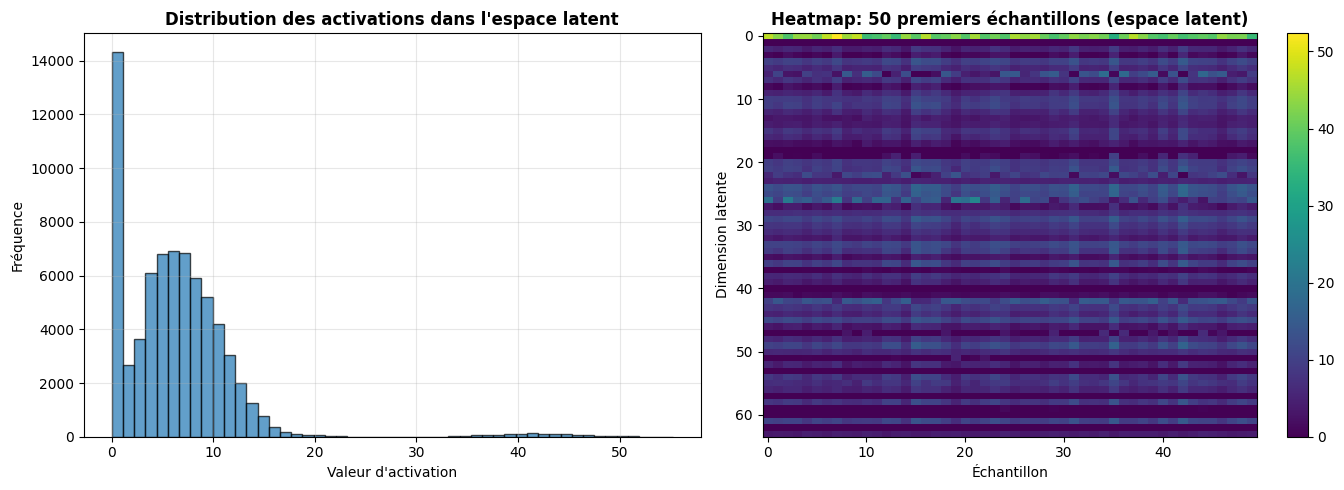


✅ QUESTION 2 COMPLÉTÉE!

RÉSUMÉ DE L'AUTOENCODER:
  - Architecture: 128×130 → 64 → 128×130
  - Compression ratio: 260.00x
  - Réduction dimensionnelle: 99.6%
  - Test MSE: 0.037242
  - Test MAE: 0.143328
  - Epochs entraînés: 8

FICHIERS SAUVEGARDÉS:
  ✓ best_autoencoder.keras (meilleur modèle)

PROCHAINE ÉTAPE:
  → Question 3: Utiliser l'encoder pré-entraîné pour extraire des features


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# ============================================================================
# QUESTION 2: BUILD AN AUTOENCODER TO COMPRESS AND DENOISE FEATURES
# ============================================================================
# Objectif: Apprendre des représentations compressées des spectrogrammes
# de manière NON SUPERVISÉE (sans utiliser les labels d'émotions)

print("\n" + "="*70)
print("QUESTION 2: CONSTRUCTION ET ENTRAÎNEMENT DE L'AUTOENCODER")
print("="*70)

# Supposons que X_train, X_val, X_test sont déjà chargés depuis Q1
# Shape attendue: (n_samples, 128, 130, 1)

# Configuration
N_MELS = 128
TIME_STEPS = 130
LATENT_DIM = 64  # Dimension du bottleneck
BATCH_SIZE = 32
EPOCHS_AE = 30

# ============================================================================
# 2.1 CONSTRUCTION DE L'AUTOENCODER
# ============================================================================

def build_autoencoder(input_shape, latent_dim=64):
    """
    Construit un Autoencoder convolutionnel pour compresser et débruiter.

    Un Autoencoder se compose de deux parties:
    1. ENCODER: Compresse l'input vers un espace latent de dimension réduite
    2. DECODER: Reconstruit l'input original à partir de l'espace latent

    Architecture:
    Input (128×130×1) → Encoder → Latent Space (64) → Decoder → Output (128×130×1)

    Args:
        input_shape: Tuple (height, width, channels) - ex: (128, 130, 1)
        latent_dim: Dimension de l'espace latent (bottleneck)

    Returns:
        autoencoder: Modèle complet (reconstruction)
        encoder: Partie encodeur uniquement
        decoder: Partie décodeur uniquement
    """

    # ========== PARTIE 1: ENCODER ==========
    print("\n--- Construction de l'Encoder ---")

    encoder_input = layers.Input(shape=input_shape, name='encoder_input')

    # Block 1: Réduction 128×130 → 64×65
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='enc_conv1')(encoder_input)
    x = layers.BatchNormalization(name='enc_bn1')(x)
    x = layers.MaxPooling2D((2, 2), name='enc_pool1')(x)
    print(f"  Après Block 1: {x.shape[1:]} (64×65×32)")

    # Block 2: Réduction 64×65 → 32×32
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='enc_conv2')(x)
    x = layers.BatchNormalization(name='enc_bn2')(x)
    x = layers.MaxPooling2D((2, 2), name='enc_pool2')(x)
    print(f"  Après Block 2: {x.shape[1:]} (32×32×64)")

    # Block 3: Réduction 32×32 → 16×16
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='enc_conv3')(x)
    x = layers.BatchNormalization(name='enc_bn3')(x)
    x = layers.MaxPooling2D((2, 2), name='enc_pool3')(x)
    print(f"  Après Block 3: {x.shape[1:]} (16×16×128)")

    # Flatten et projection vers l'espace latent
    x = layers.Flatten(name='enc_flatten')(x)
    encoded = layers.Dense(latent_dim, activation='relu', name='latent_space')(x)
    print(f"  Espace latent: ({latent_dim},)")

    encoder = models.Model(encoder_input, encoded, name='encoder')

    # ========== PARTIE 2: DECODER ==========
    print("\n--- Construction du Decoder ---")

    decoder_input = layers.Input(shape=(latent_dim,), name='decoder_input')

    # Calculer les dimensions après les MaxPooling
    h = input_shape[0] // 8  # 128 // 8 = 16
    w = input_shape[1] // 8  # 130 // 8 = 16

    # Dense et reshape pour reconstruire la forme spatiale
    x = layers.Dense(h * w * 128, activation='relu', name='dec_dense')(decoder_input)
    x = layers.Reshape((h, w, 128), name='dec_reshape')(x)
    print(f"  Après reshape: {x.shape[1:]} (16×16×128)")

    # Block 1: Expansion 16×16 → 32×32
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', name='dec_conv1')(x)
    x = layers.UpSampling2D((2, 2), name='dec_up1')(x)
    print(f"  Après Block 1: {x.shape[1:]} (32×32×128)")

    # Block 2: Expansion 32×32 → 64×64
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', name='dec_conv2')(x)
    x = layers.UpSampling2D((2, 2), name='dec_up2')(x)
    print(f"  Après Block 2: {x.shape[1:]} (64×64×64)")

    # Block 3: Expansion 64×64 → 128×128
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', name='dec_conv3')(x)
    x = layers.UpSampling2D((2, 2), name='dec_up3')(x)
    print(f"  Après Block 3: {x.shape[1:]} (128×128×32)")

    # Reconstruction finale avec sigmoid (sortie entre 0 et 1)
    decoded = layers.Conv2D(input_shape[-1], (3, 3), activation='sigmoid',
                           padding='same', name='dec_output')(x)

    # Ajuster à la taille originale si nécessaire (128×128 → 128×130)
    if decoded.shape[2] != input_shape[1]:
        # Utiliser Cropping ou ZeroPadding pour ajuster
        pad_width = input_shape[1] - decoded.shape[2]
        if pad_width > 0:
            decoded = layers.ZeroPadding2D(padding=((0, 0), (0, pad_width)),
                                          name='dec_padding')(decoded)
        else:
            decoded = layers.Cropping2D(cropping=((0, 0), (0, -pad_width)),
                                       name='dec_cropping')(decoded)

    print(f"  Sortie finale: {decoded.shape[1:]} (128×130×1)")

    decoder = models.Model(decoder_input, decoded, name='decoder')

    # ========== PARTIE 3: AUTOENCODER COMPLET ==========
    autoencoder_output = decoder(encoder(encoder_input))
    autoencoder = models.Model(encoder_input, autoencoder_output, name='autoencoder')

    return autoencoder, encoder, decoder


# Construire l'autoencoder
input_shape = (N_MELS, TIME_STEPS, 1)
autoencoder, encoder, decoder = build_autoencoder(input_shape, latent_dim=LATENT_DIM)

# ============================================================================
# 2.2 AFFICHAGE DES ARCHITECTURES
# ============================================================================

print("\n" + "="*70)
print("ARCHITECTURES DES MODÈLES")
print("="*70)

print("\n1. ENCODER (Compresseur):")
print("-" * 40)
encoder.summary()

print("\n2. DECODER (Reconstructeur):")
print("-" * 40)
decoder.summary()

print("\n3. AUTOENCODER COMPLET:")
print("-" * 40)
autoencoder.summary()

# Calcul du ratio de compression
original_size = N_MELS * TIME_STEPS
compressed_size = LATENT_DIM
compression_ratio = original_size / compressed_size

print(f"\n{'='*60}")
print(f"STATISTIQUES DE COMPRESSION")
print(f"{'='*60}")
print(f"Taille originale: {original_size} paramètres")
print(f"Taille compressée: {compressed_size} paramètres")
print(f"Ratio de compression: {compression_ratio:.2f}x")
print(f"Réduction: {(1 - compressed_size/original_size)*100:.1f}%")
print(f"{'='*60}\n")

# ============================================================================
# 2.3 COMPILATION DU MODÈLE
# ============================================================================

print("\n--- Compilation de l'Autoencoder ---")

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error pour la reconstruction
    metrics=['mae']  # Mean Absolute Error comme métrique additionnelle
)

print("✅ Modèle compilé avec:")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Loss: MSE (Mean Squared Error)")
print("  - Metrics: MAE (Mean Absolute Error)")

# ============================================================================
# 2.4 PRÉ-ENTRAÎNEMENT DE L'AUTOENCODER (NON SUPERVISÉ)
# ============================================================================

print("\n" + "="*70)
print("PRÉ-ENTRAÎNEMENT DE L'AUTOENCODER (UNSUPERVISED LEARNING)")
print("="*70)
print("\n⚠️  IMPORTANT: L'autoencoder apprend à reconstruire l'input")
print("   SANS utiliser les labels d'émotions (apprentissage non supervisé)!")

# Callbacks
callbacks_ae = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_autoencoder.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("\nDébut de l'entraînement...")
print(f"Epochs: {EPOCHS_AE}")
print(f"Batch size: {BATCH_SIZE}")

# Entraînement: X_train comme input ET target (reconstruction)
history_ae = autoencoder.fit(
    X_train, X_train,  # Input = Target pour la reconstruction!
    validation_data=(X_val, X_val),
    epochs=EPOCHS_AE,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_ae,
    verbose=1
)

print("\n✅ Entraînement terminé!")

# ============================================================================
# 2.5 ÉVALUATION DE L'AUTOENCODER
# ============================================================================

print("\n" + "="*70)
print("ÉVALUATION DE L'AUTOENCODER")
print("="*70)

# Évaluation sur test set
test_loss, test_mae = autoencoder.evaluate(X_test, X_test, verbose=0)

print(f"\nMétriques sur Test Set:")
print(f"  Reconstruction Loss (MSE): {test_loss:.6f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.6f}")

# ============================================================================
# 2.6 VISUALISATION DES RECONSTRUCTIONS
# ============================================================================

print("\n--- Génération des visualisations ---")

n_samples = 6
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
samples = X_test[sample_indices]
reconstructed = autoencoder.predict(samples, verbose=0)

# Calculer l'erreur de reconstruction par échantillon
reconstruction_errors = np.mean((samples - reconstructed) ** 2, axis=(1, 2, 3))

fig, axes = plt.subplots(3, n_samples, figsize=(18, 9))
fig.suptitle('Autoencoder: Original vs Reconstructed vs Difference', fontsize=16, fontweight='bold')

for i in range(n_samples):
    # Original
    im1 = axes[0, i].imshow(samples[i, :, :, 0], aspect='auto', origin='lower',
                            cmap='viridis', vmin=0, vmax=1)
    axes[0, i].set_title('Original', fontsize=10)
    axes[0, i].axis('off')

    # Reconstructed
    im2 = axes[1, i].imshow(reconstructed[i, :, :, 0], aspect='auto', origin='lower',
                            cmap='viridis', vmin=0, vmax=1)
    axes[1, i].set_title('Reconstructed', fontsize=10)
    axes[1, i].axis('off')

    # Difference (erreur)
    diff = np.abs(samples[i, :, :, 0] - reconstructed[i, :, :, 0])
    im3 = axes[2, i].imshow(diff, aspect='auto', origin='lower',
                            cmap='hot', vmin=0, vmax=0.5)
    axes[2, i].set_title(f'Error: {reconstruction_errors[i]:.4f}', fontsize=10)
    axes[2, i].axis('off')

# Ajouter les colorbars
fig.colorbar(im1, ax=axes[0, :], orientation='vertical', fraction=0.02, pad=0.04)
fig.colorbar(im2, ax=axes[1, :], orientation='vertical', fraction=0.02, pad=0.04)
fig.colorbar(im3, ax=axes[2, :], orientation='vertical', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()

# ============================================================================
# 2.7 VISUALISATION DE L'HISTORIQUE D'ENTRAÎNEMENT
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss (MSE)
axes[0].plot(history_ae.history['loss'], label='Train Loss (MSE)', linewidth=2)
axes[0].plot(history_ae.history['val_loss'], label='Validation Loss (MSE)', linewidth=2)
axes[0].set_title('Autoencoder Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history_ae.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history_ae.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Autoencoder Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 2.8 ANALYSE DE L'ESPACE LATENT
# ============================================================================

print("\n--- Analyse de l'espace latent ---")

# Encoder tous les spectrogrammes du test set
latent_representations = encoder.predict(X_test, verbose=0)

print(f"\nShape des représentations latentes: {latent_representations.shape}")
print(f"Min: {latent_representations.min():.4f}")
print(f"Max: {latent_representations.max():.4f}")
print(f"Mean: {latent_representations.mean():.4f}")
print(f"Std: {latent_representations.std():.4f}")

# Visualiser la distribution des activations dans l'espace latent
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des activations
axes[0].hist(latent_representations.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution des activations dans l\'espace latent',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Valeur d\'activation')
axes[0].set_ylabel('Fréquence')
axes[0].grid(True, alpha=0.3)

# Heatmap des premières représentations latentes
axes[1].imshow(latent_representations[:50].T, aspect='auto', cmap='viridis')
axes[1].set_title('Heatmap: 50 premiers échantillons (espace latent)',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Échantillon')
axes[1].set_ylabel('Dimension latente')
plt.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.show()

# ============================================================================
# 2.9 RÉSUMÉ FINAL
# ============================================================================

print("\n" + "="*70)
print("✅ QUESTION 2 COMPLÉTÉE!")
print("="*70)

print("\nRÉSUMÉ DE L'AUTOENCODER:")
print(f"  - Architecture: {N_MELS}×{TIME_STEPS} → {LATENT_DIM} → {N_MELS}×{TIME_STEPS}")
print(f"  - Compression ratio: {compression_ratio:.2f}x")
print(f"  - Réduction dimensionnelle: {(1 - compressed_size/original_size)*100:.1f}%")
print(f"  - Test MSE: {test_loss:.6f}")
print(f"  - Test MAE: {test_mae:.6f}")
print(f"  - Epochs entraînés: {len(history_ae.history['loss'])}")

print("\nFICHIERS SAUVEGARDÉS:")
print("  ✓ best_autoencoder.keras (meilleur modèle)")

print("\nPROCHAINE ÉTAPE:")
print("  → Question 3: Utiliser l'encoder pré-entraîné pour extraire des features")
print("="*70)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Configuration chargée avec succès!
🎭 Émotions: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'] (6 classes)
⚙️  Batch Size: 16, Learning Rate: 0.0005
Found 7446 audio files
Loaded 7446 spectrograms
Shape: (7446, 128, 130)

Class Distribution:
  ANG: 1271
  DIS: 1272
  FEA: 1271
  HAP: 1271
  NEU: 1087
  SAD: 1274

Data Split:
  Train: (5212, 128, 130, 1)
  Validation: (1117, 128, 130, 1)
  Test: (1117, 128, 130, 1)

AUTOENCODER ARCHITECTURE


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 130, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │     2,487,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 130, 1)    │     3,091,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,578,241 (21.28 MB)

 Trainable params: 5,577,281 (21.28 MB)

 Non-trainable params: 960 (3.75 KB)


Training Autoencoder...
Epoch 1/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - loss: 0.2395 - mae: 0.2493 - val_loss: 0.1222 - val_mae: 0.3018 - learning_rate: 5.0000e-04
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0712 - mae: 0.2084 - val_loss: 0.0763 - val_mae: 0.2208 - learning_rate: 5.0000e-04
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0707 - mae: 0.2069 - val_loss: 0.0743 - val_mae: 0.2168 - learning_rate: 5.0000e-04
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0703 - mae: 0.2055 - val_loss: 0.0709 - val_mae: 0.2069 - learning_rate: 5.0000e-04
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0702 - mae: 0.2052 - val_loss: 0.0703 - val_mae: 0.2059 - learning_rate: 5.0000e-04
Epoch 6/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0697 - mae: 0.2044 - val_loss: 0.0706 - val_mae: 0.2063 - learning_rate: 5.0000e-04
Epoch 7/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0693 - mae: 0.2032 - val_loss

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 128, 130, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │     2,487,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,563,142 (9.78 MB)

 Trainable params: 75,334 (294.27 KB)

 Non-trainable params: 2,487,808 (9.49 MB)


Training Classifier (Frozen Encoder)...
Epoch 1/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.2608 - loss: 2.3691 - val_accuracy: 0.4342 - val_loss: 1.7297 - learning_rate: 5.0000e-04
Epoch 2/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3656 - loss: 1.8704 - val_accuracy: 0.4351 - val_loss: 1.6485 - learning_rate: 5.0000e-04
Epoch 3/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3785 - loss: 1.7999 - val_accuracy: 0.4423 - val_loss: 1.6206 - learning_rate: 5.0000e-04
Epoch 4/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3839 - loss: 1.7734 - val_accuracy: 0.4816 - val_loss: 1.5918 - learning_rate: 5.0000e-04
Epoch 5/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3726 - loss: 1.7375 - val_accuracy: 0.4790 - val_loss: 1.5766 - learning_rate: 5.0000e-04
Epoch 6/40
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4151 - loss: 1.6843 - val_accuracy: 0.4700 - val_loss: 1.5552 - learning_rate: 5.0000e-04
Epoch 7/40
326/326 ━━

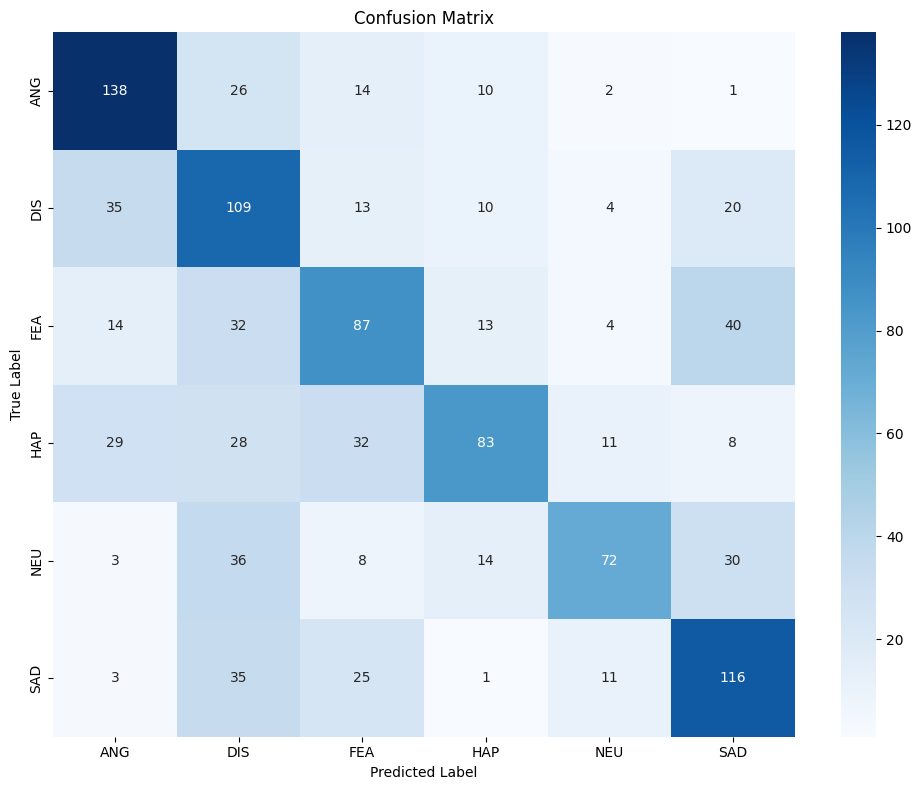

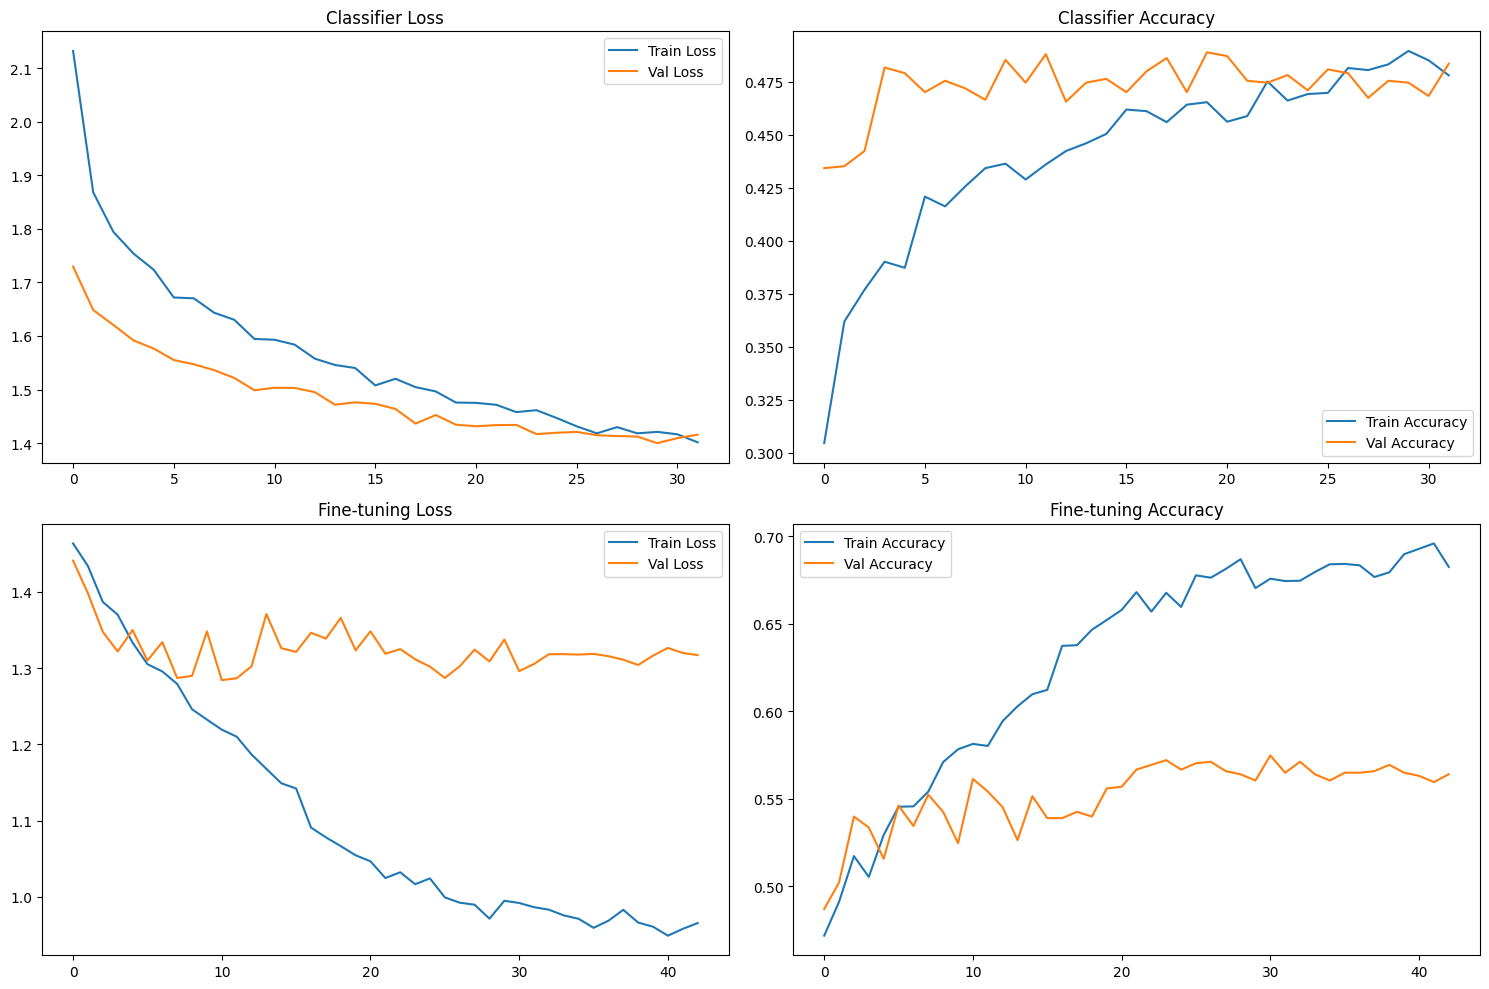


✅ Training Complete!


In [ ]:
# ============================================================================
# EMOTION RECOGNITION - OPTIMIZED VERSION FOR BETTER ACCURACY
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# PART 1: SETUP & CONFIGURATION
# ============================================================================

drive.mount('/content/drive')

# IMPROVED HYPERPARAMETERS
dataset_path = "/content/drive/MyDrive/AudioWAV"
SAMPLE_RATE = 22050
N_MELS = 128
TIME_STEPS = 130
LATENT_DIM = 128  # Increased from 64 for better representation
BATCH_SIZE = 16   # Reduced for better gradient updates
EPOCHS_AE = 50    # More epochs for autoencoder
EPOCHS_CLASSIFIER = 40
EPOCHS_FINETUNE = 50
EMOTIONS = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
LEARNING_RATE = 0.0005  # Lower learning rate for stability
DROPOUT_RATE = 0.3
L2_REGULARIZATION = 0.001

print("✅ Configuration chargée avec succès!")
print(f"🎭 Émotions: {EMOTIONS} ({len(EMOTIONS)} classes)")
print(f"⚙️  Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}")

# ============================================================================
# PART 2: IMPROVED AUDIO FEATURE EXTRACTION
# ============================================================================

def extract_advanced_melspectrogram(audio_path, sr=22050, n_mels=128, target_length=130):
    """Extract and augment mel-spectrogram with improved normalization."""
    try:
        y, sr = librosa.load(audio_path, sr=sr, duration=3)

        # Generate mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # IMPROVEMENT: Use robust normalization (mean-std instead of min-max)
        mean = np.mean(mel_spec_db)
        std = np.std(mel_spec_db)
        mel_spec_norm = (mel_spec_db - mean) / (std + 1e-6)
        mel_spec_norm = np.clip(mel_spec_norm, -3, 3)  # Clip outliers

        # Resize temporal dimension
        current_length = mel_spec_norm.shape[1]
        if current_length < target_length:
            pad_width = target_length - current_length
            mel_spec_norm = np.pad(mel_spec_norm, ((0, 0), (0, pad_width)), mode='edge')
        else:
            mel_spec_norm = mel_spec_norm[:, :target_length]

        return mel_spec_norm
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def load_dataset_improved(dataset_path, target_length=130):
    """Load dataset with improved handling."""
    audio_files = list(Path(dataset_path).glob("*.wav"))

    if len(audio_files) == 0:
        raise ValueError(f"No .wav files found in {dataset_path}")

    print(f"Found {len(audio_files)} audio files")

    spectrograms = []
    labels = []

    for audio_file in audio_files:
        filename = audio_file.stem
        parts = filename.split('_')

        if len(parts) >= 3:
            emotion = parts[2]
            if emotion in EMOTIONS:
                mel_spec = extract_advanced_melspectrogram(str(audio_file), target_length=target_length)
                if mel_spec is not None:
                    spectrograms.append(mel_spec)
                    labels.append(emotion)

    spectrograms = np.array(spectrograms)
    labels = np.array(labels)

    print(f"Loaded {len(spectrograms)} spectrograms")
    print(f"Shape: {spectrograms.shape}")

    return spectrograms, labels

# Load data
X_data, y_data = load_dataset_improved(dataset_path, target_length=TIME_STEPS)

# Show class distribution
unique, counts = np.unique(y_data, return_counts=True)
print("\nClass Distribution:")
for emotion, count in zip(unique, counts):
    print(f"  {emotion}: {count}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

# Add channel dimension
X_data = np.expand_dims(X_data, axis=-1)

# Normalize data (IMPORTANT for better training)
X_data = X_data / np.max(np.abs(X_data))

# Convert to categorical
y_categorical = to_categorical(y_encoded, num_classes=len(EMOTIONS))

# Split with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"\nData Split:")
print(f"  Train: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")

# ============================================================================
# PART 3: IMPROVED AUTOENCODER
# ============================================================================

def build_improved_autoencoder(input_shape, latent_dim=128):
    """Build autoencoder with regularization and batch normalization."""

    # ENCODER
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    encoded = layers.Dense(latent_dim, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(x)

    encoder = models.Model(encoder_input, encoded, name='encoder')

    # DECODER
    decoder_input = layers.Input(shape=(latent_dim,), name='decoder_input')

    h, w = input_shape[0] // 16, input_shape[1] // 16
    x = layers.Dense(h * w * 256, activation='relu')(decoder_input)
    x = layers.Reshape((h, w, 256))(x)

    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Adjust output size
    if decoded.shape[2] != input_shape[1]:
        pad_width = input_shape[1] - decoded.shape[2]
        if pad_width > 0:
            decoded = layers.ZeroPadding2D(padding=((0, 0), (0, pad_width)))(decoded)
        else:
            decoded = layers.Cropping2D(cropping=((0, 0), (0, -pad_width)))(decoded)

    decoder = models.Model(decoder_input, decoded, name='decoder')

    # FULL AUTOENCODER
    autoencoder_output = decoder(encoder(encoder_input))
    autoencoder = models.Model(encoder_input, autoencoder_output, name='autoencoder')

    return autoencoder, encoder, decoder

# Build autoencoder
input_shape = (N_MELS, TIME_STEPS, 1)
autoencoder, encoder, decoder = build_improved_autoencoder(input_shape, latent_dim=LATENT_DIM)

print("\n" + "="*70)
print("AUTOENCODER ARCHITECTURE")
print("="*70)
autoencoder.summary()

# Compile autoencoder
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

# Train autoencoder
print("\nTraining Autoencoder...")
callbacks_ae = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
]

history_ae = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS_AE,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_ae,
    verbose=1
)

# ============================================================================
# PART 4: IMPROVED CLASSIFIER WITH TRANSFER LEARNING
# ============================================================================

def build_improved_classifier(encoder, latent_dim, num_classes, freeze_encoder=True):
    """Build classifier using pre-trained encoder features."""

    encoder_input = layers.Input(shape=(N_MELS, TIME_STEPS, 1), name='input')

    # Use frozen encoder for feature extraction
    if freeze_encoder:
        encoder.trainable = False

    encoded = encoder(encoder_input)

    # Classification head with regularization
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    x = layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    x = layers.Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(x)
    x = layers.Dropout(DROPOUT_RATE/2)(x)

    output = layers.Dense(num_classes, activation='softmax')(x)

    classifier = models.Model(encoder_input, output, name='classifier')

    return classifier

# Build and train classifier
classifier = build_improved_classifier(encoder, LATENT_DIM, len(EMOTIONS), freeze_encoder=True)

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*70)
print("CLASSIFIER ARCHITECTURE")
print("="*70)
classifier.summary()

print("\nTraining Classifier (Frozen Encoder)...")
callbacks_clf = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
]

history_clf = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_CLASSIFIER,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_clf,
    verbose=1
)

# ============================================================================
# PART 5: FINE-TUNING
# ============================================================================

print("\n" + "="*70)
print("FINE-TUNING PHASE (Unfroze Encoder)")
print("="*70)

# Unfreeze encoder for fine-tuning
encoder.trainable = True

# Lower learning rate for fine-tuning
classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning Classifier...")
history_ft = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_FINETUNE,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_clf,
    verbose=1
)

# ============================================================================
# PART 6: EVALUATION
# ============================================================================

print("\n" + "="*70)
print("EVALUATION ON TEST SET")
print("="*70)

y_pred_probs = classifier.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history_clf.history['loss'], label='Train Loss')
axes[0, 0].plot(history_clf.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Classifier Loss')
axes[0, 0].legend()

axes[0, 1].plot(history_clf.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history_clf.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Classifier Accuracy')
axes[0, 1].legend()

axes[1, 0].plot(history_ft.history['loss'], label='Train Loss')
axes[1, 0].plot(history_ft.history['val_loss'], label='Val Loss')
axes[1, 0].set_title('Fine-tuning Loss')
axes[1, 0].legend()

axes[1, 1].plot(history_ft.history['accuracy'], label='Train Accuracy')
axes[1, 1].plot(history_ft.history['val_accuracy'], label='Val Accuracy')
axes[1, 1].set_title('Fine-tuning Accuracy')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Training Complete!")
print("="*70)